In [1]:
# branching process model
# t is distribution of infection time
# r is number of replications at each generation
# e is error rate
# g is rate of replication

import numpy as np
import scipy.stats as st


t = 10
g = 0.5
r = 5
e = 0.00005

def BPM_det(t, g, r, e):
    n = [1, 0, 0, 0, 0, 0] # number of non-mutated viruses
    i = 0 # starting time
    while i < t:
        i += g
        n = [i*r for i in n] # number of viruses
        fourtofive = st.binom.rvs(n[4], e, size = 1)[0]
        threetofour = st.binom.rvs(n[3], e, size = 1)[0]
        twotothree = st.binom.rvs(n[2], e, size = 1)[0]
        onetotwo = st.binom.rvs(n[1], e, size = 1)[0]
        zerotoone = st.binom.rvs(n[0], e, size = 1)[0]
        n[5] = n[5] + fourtofive
        n[4] = n[4] + threetofour - fourtofive
        n[3] = n[3] + twotothree - threetofour
        n[2] = n[2] + onetotwo - twotothree
        n[1] = n[1] + zerotoone - onetotwo
        n[0] = n[0] - zerotoone
    return n
test = BPM_det(t,g,r,e)
print(test)
print(np.sum(test))

[95299577106113, 67832328593, 22203010, 2909, 0, 0]
95367431640625


In [2]:
# stochastic BPM model
r = 5 # each infected cell produces r_i^2 virions of the ith mutant type
p = 10**-5
mu = [1, p, p**2, p**3, p**4, p**5]
mu[0] -= np.sum(mu[1:5])
g = 0.5
def BPM_st(t, g, r, mu):
    n = [1, 0, 0, 0, 0, 0]
    i = 0 # starting time
    while i < t:
        i += g
        n[0] = st.poisson.rvs(n[0]*r*mu[0])
        n[1] = st.poisson.rvs(r*(n[1]*mu[0] + n[0]*mu[1]))
        n[2] = st.poisson.rvs(r*(n[2]*mu[0] + n[1]*mu[1] + n[0]*mu[2]))
        n[3] = st.poisson.rvs(r*(n[3]*mu[0] + n[2]*mu[1] + n[1]*mu[2] + n[0]*mu[3]))
        n[4] = st.poisson.rvs(r*(n[4]*mu[0] + n[3]*mu[1] + n[2]*mu[2] + n[1]*mu[3] + n[0]*mu[4]))
        n[5] = st.poisson.rvs(r*(n[5]*mu[0] + n[4]*mu[1] + n[3]*mu[2] + n[2]*mu[3] + n[1]*mu[4] + n[0]*mu[5]))
    return n

print(BPM_st(10, g, 5, mu))


[47675037670200, 42191751057, 14878770, 3022, 1, 0]


In [3]:
%%timeit -r 5 -n 1000
BPM_st(10, g, 5, mu)

1.51 ms ± 27.8 µs per loop (mean ± std. dev. of 5 runs, 1,000 loops each)


In [4]:
#Vectorised version of the BPM
def BPM_st_vectorised(t, g, r, mu, initial_v):
    n_list = [[initial_v, 0, 0, 0, 0, 0]]
    i = 0 # starting time
    count=0 #index
    while (i <= t - g):
        i += g
        n = np.copy(n_list[count])
        n_new = np.zeros(6)
        n_new[0] = st.poisson.rvs(n[0]*r[count]*mu[0])
        n_new[1] = st.poisson.rvs(r[count]*(n[1]*mu[0])) +  st.poisson.rvs(r[count] * (n[0]*mu[1]))
        n_new[2] = st.poisson.rvs(r[count]*(n[2]*mu[0])) +  st.poisson.rvs(r[count] * ( n[1]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[2]))
        n_new[3] = st.poisson.rvs(r[count]*(n[3]*mu[0] )) +  st.poisson.rvs(r[count] * ( n[2]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[1]*mu[2] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[3]))
        n_new[4] = st.poisson.rvs(r[count]*(n[4]*mu[0] )) +  st.poisson.rvs(r[count] * ( n[3]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[2]*mu[2] )) +  st.poisson.rvs(r[count] * ( n[1]*mu[3] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[4]))
        n_new[5] = st.poisson.rvs(r[count]*(n[5]*mu[0] )) +  st.poisson.rvs(r[count] * ( n[4]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[3]*mu[2] )) +  st.poisson.rvs(r[count] * ( n[2]*mu[3] )) +  st.poisson.rvs(r[count] * ( n[1]*mu[4] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[5]))
        count +=1
        n_list.append(np.copy(n_new))
        #stores the virion counts at every time point
    return n_list

In [5]:
import simfromcsv

#Get the r and lifespan parameters
g = 0.5 / 2
params = simfromcsv.getBPMparams(g)
Lifespans = params[0]
r_vals = params[1]
Deaths = params[2]



In [24]:
#Set parameters
p = 10**-5
mu = [1, p, p**2, p**3, p**4, p**5]
mu[0] -= np.sum(mu[1:])
initial_viral_load = 1e6

#Number of people (in 1000s)
numberpeople1000s = 1000



In [7]:
#Initialise lists
ns = []
n_i_lists = []

#Loop through and do a BPM for each person
for i in range(0,len(Lifespans)):
    print(str((i + 1) / len(Lifespans) * 100 ) + "%")
    for j in range(0, numberpeople1000s):
        t = Lifespans[i]
        #t = 7
        r = r_vals[i]
        #r = np.ones(120) * 2

        out = np.array(BPM_st_vectorised(t,g,r,mu,initial_viral_load))
        ns.append(np.sum(out))
        ni_list = []
        for k in range(0, 6):
            ni_list.append(out[:,k])
        n_i_lists.append(ni_list)

0.1%
0.2%
0.3%
0.4%
0.5%
0.6%
0.7000000000000001%
0.8%
0.8999999999999999%
1.0%
1.0999999999999999%
1.2%
1.3%
1.4000000000000001%
1.5%
1.6%
1.7000000000000002%
1.7999999999999998%
1.9%
2.0%
2.1%
2.1999999999999997%
2.3%
2.4%
2.5%
2.6%
2.7%
2.8000000000000003%
2.9000000000000004%
3.0%
3.1%
3.2%
3.3000000000000003%
3.4000000000000004%
3.5000000000000004%
3.5999999999999996%
3.6999999999999997%
3.8%
3.9%
4.0%
4.1000000000000005%
4.2%
4.3%
4.3999999999999995%
4.5%
4.6%
4.7%
4.8%
4.9%
5.0%
5.1%
5.2%
5.3%
5.4%
5.5%
5.6000000000000005%
5.7%
5.800000000000001%
5.8999999999999995%
6.0%
6.1%
6.2%
6.3%
6.4%
6.5%
6.6000000000000005%
6.7%
6.800000000000001%
6.9%
7.000000000000001%
7.1%
7.199999999999999%
7.3%
7.3999999999999995%
7.5%
7.6%
7.7%
7.8%
7.9%
8.0%
8.1%
8.200000000000001%
8.3%
8.4%
8.5%
8.6%
8.7%
8.799999999999999%
8.9%
9.0%
9.1%
9.2%
9.3%
9.4%
9.5%
9.6%
9.700000000000001%
9.8%
9.9%
10.0%
10.100000000000001%
10.2%
10.299999999999999%
10.4%
10.5%
10.6%
10.7%
10.8%
10.9%
11.0%
11.1%
11.2000

In [8]:
import pickle
with open('n_list.pkl', 'wb') as f:  # open a text file
    pickle.dump(n_i_lists, f) # serialize the list   
f.close()

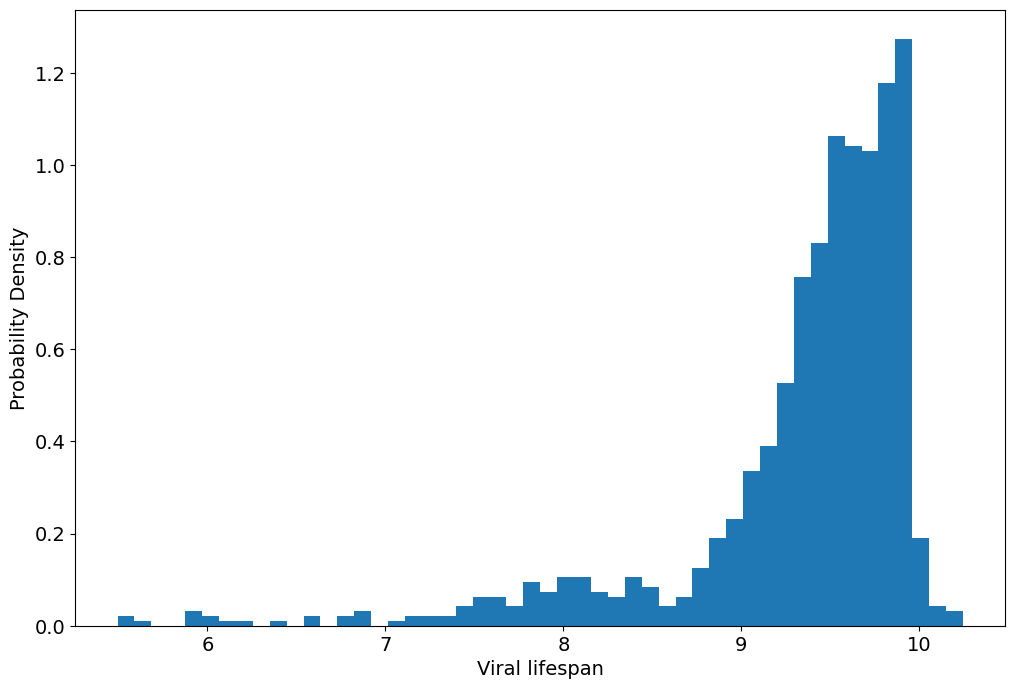

In [9]:
import matplotlib.pyplot as plt


#Set up plot
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 14
fig = plt.figure()

#Plot a histogram of lifespans
plt.hist(Lifespans,bins=50,density=True)
plt.ylabel("Probability Density")
plt.xlabel("Viral lifespan")

plt.savefig('Plots/Lifespans.pdf', dpi=1200,bbox_inches='tight')

plt.show()

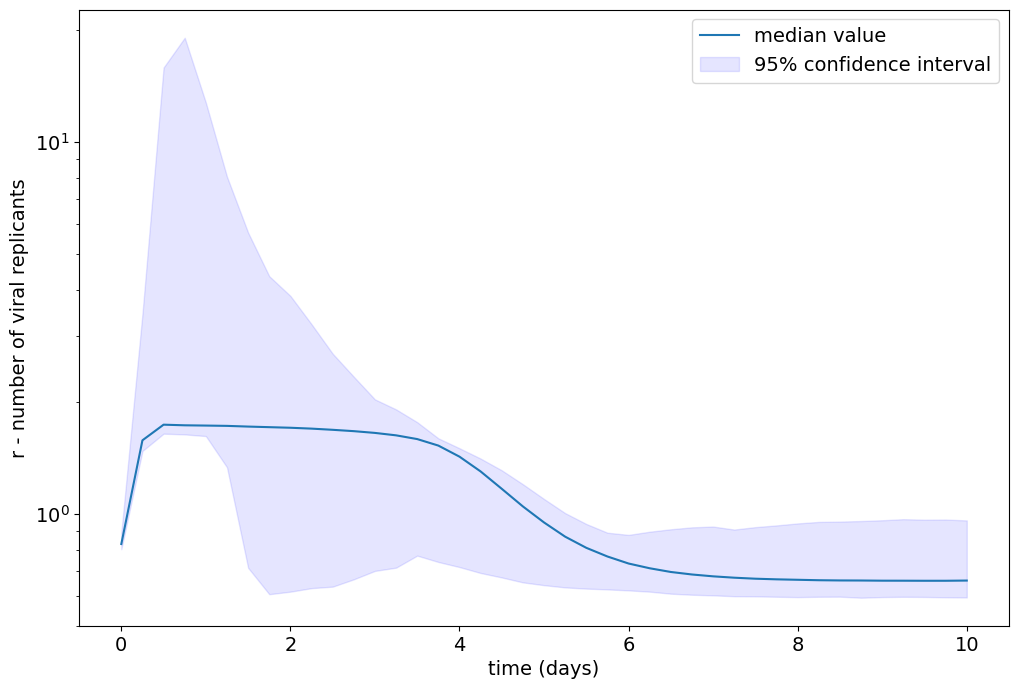

In [25]:
#Plot the median of r over time, with a 95% confidence interval
x = np.linspace(0, 10, 41)
y = np.zeros(41)
ci_u = np.zeros(41)
ci_l = np.zeros(41)
for i in range(0, 41):
    r_i = []
    for j in range(1000):
        r_i.append(r_vals[j][i])
    #calculate median and confidence interval at this time point
    y[i] = np.median(np.array(r_i))
    ci_u[i] = np.percentile(np.array(r_i), 97.5)
    ci_l[i] = np.percentile(np.array(r_i), 2.5)


fig, ax = plt.subplots()
ax.semilogy(x,y, label = 'median value')
ax.fill_between(x, (ci_l), (ci_u), color='b', alpha=.1, label="95% confidence interval")
ax.legend()
plt.ylabel('r - number of viral replicants')
plt.xlabel('time (days)')
plt.savefig('Plots/r_CI.pdf', dpi=1200,bbox_inches='tight')
plt.show()

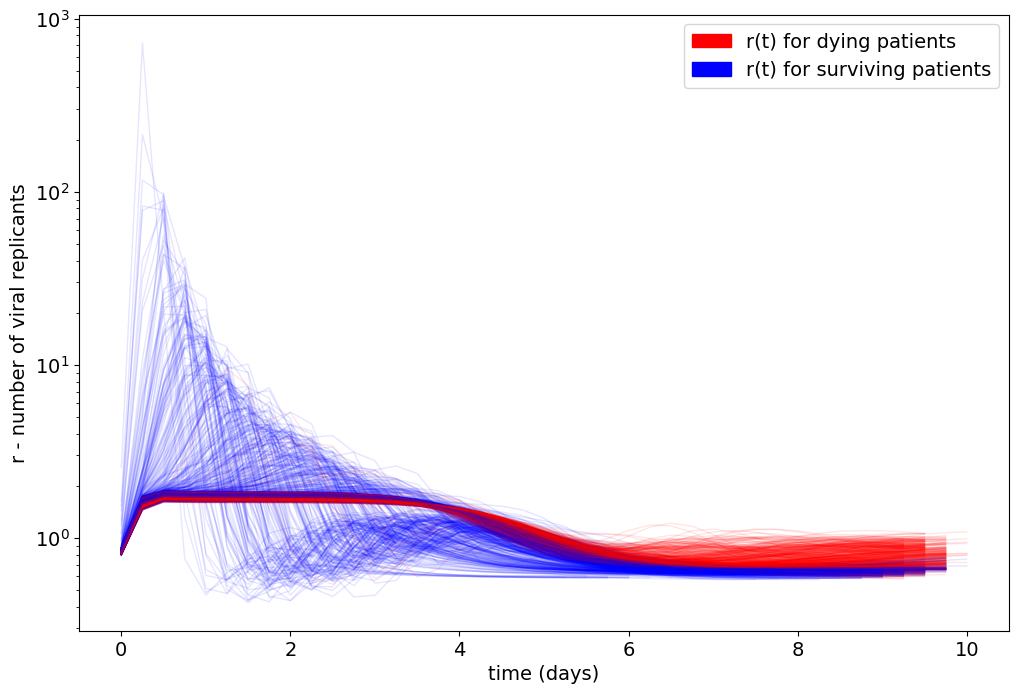

In [26]:
import matplotlib.patches as mpatches

for j in range(1000):
    L = Lifespans[j]
    gens = int(L / g) + 1
    r_curve = r_vals[j]
    if Deaths[j]:
        plt.semilogy(x[0:gens], r_curve[0:gens], 'r', linewidth=1, alpha = 0.1)
    else:
        plt.semilogy(x[0:gens], r_curve[0:gens], 'b', linewidth=1, alpha = 0.1)


red_patch = mpatches.Patch(color='red', label='r(t) for dying patients')
blue_patch = mpatches.Patch(color='blue', label='r(t) for surviving patients')

plt.legend(handles=[red_patch, blue_patch])
plt.ylabel('r - number of viral replicants')
plt.xlabel('time (days)')
plt.savefig('Plots/r_surv_death.pdf', dpi=1200,bbox_inches='tight')

plt.show()

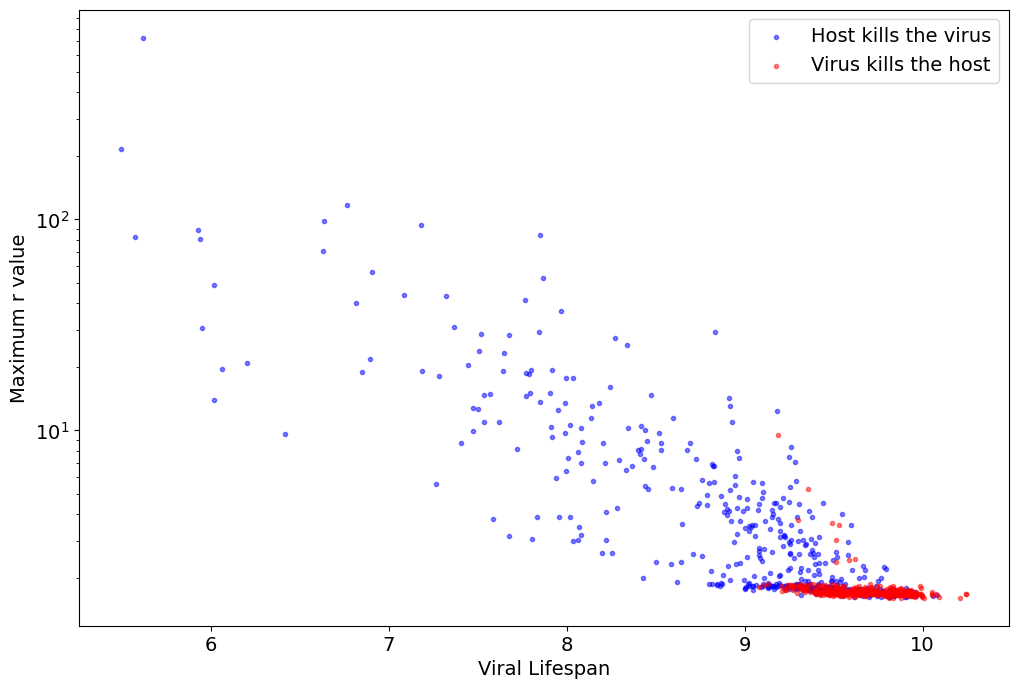

In [27]:
#Plot max r value vs lifespan
ma = []
for i in range(0,len(Lifespans)):
    ma.append(max(r_vals[i]))


dead_lifespans = []
ma_dead = []

end_of_infection = []
ma_end = []

for i in range(0,len(Lifespans)):
    if Deaths[i]:
        dead_lifespans.append(Lifespans[i])
        ma_dead.append(ma[i])
        #ma_dead.append(np.log(np.log(ma[i])))

    else:
        end_of_infection.append(Lifespans[i])
        ma_end.append(ma[i])
        #ma_end.append(np.log(np.log(ma[i])))



fig, ax = plt.subplots()
ax.scatter(end_of_infection, ma_end, c='b', label='Host kills the virus', marker=".", alpha = 0.5)
ax.scatter(dead_lifespans, ma_dead, c='r', label='Virus kills the host', marker=".", alpha = 0.5)


#ax.set_yscale('linear')
ax.set_yscale('log')

plt.legend()
#plt.ylabel('Maximum loglog(r) value')
plt.ylabel('Maximum r value')
plt.xlabel('Viral Lifespan')
plt.savefig('Plots/max_r.pdf', dpi=1200,bbox_inches='tight')
plt.show()

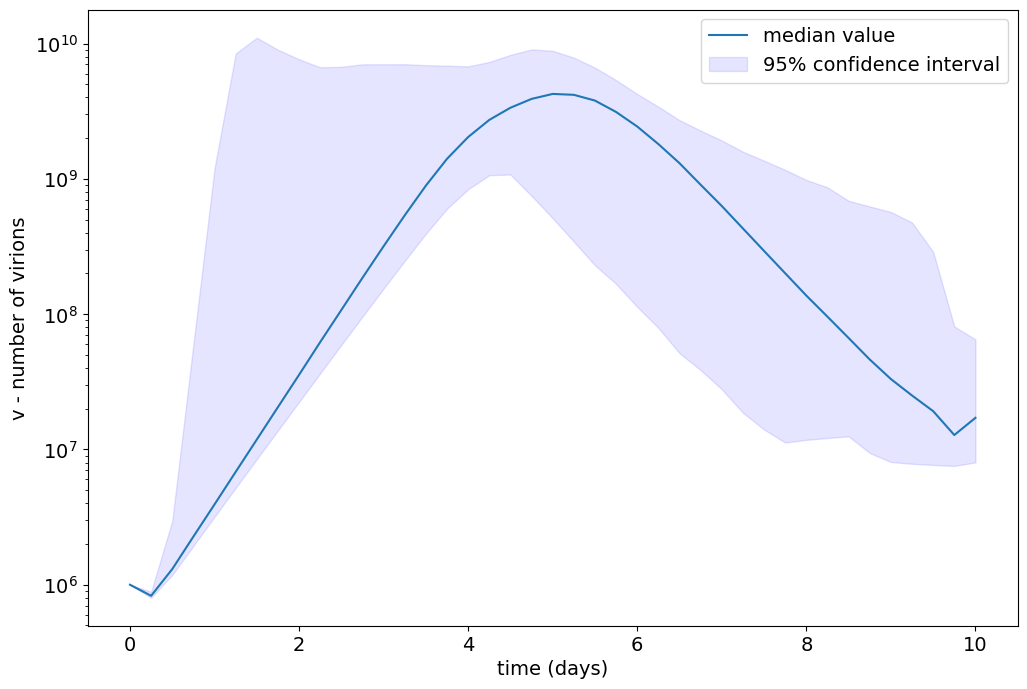

In [28]:
#plot median virion count over time, with 95% confidence interval
#initialise arrays
x = np.linspace(0, 10, 41)
y = np.zeros(41)
meanV = np.zeros(41)
ci_u = np.zeros(41)
ci_l = np.zeros(41)
for i in range(0, 41):
    v_i = []
    for j in range(1000):
        for k in range(0,numberpeople1000s):
            L = Lifespans[j]
            gens = int(L / g)
            if i <= gens:
                v_i.append(n_i_lists[k + numberpeople1000s * j][0][i])
    #calculate median, mean and confidence interval
    y[i] = np.median(np.array(v_i))
    ci_u[i] = np.percentile(np.array(v_i), 97.5)
    ci_l[i] = np.percentile(np.array(v_i), 2.5)
    meanV[i] = np.mean(np.array(v_i))

#plot
fig, ax = plt.subplots()
ax.semilogy(x,y, label = 'median value')
ax.fill_between(x, (ci_l), (ci_u), color='b', alpha=.1, label="95% confidence interval")
ax.legend()
plt.ylabel('v - number of virions')
plt.xlabel('time (days)')
plt.savefig('Plots/v_bpm_CI.pdf', dpi=1200,bbox_inches='tight')
plt.show()

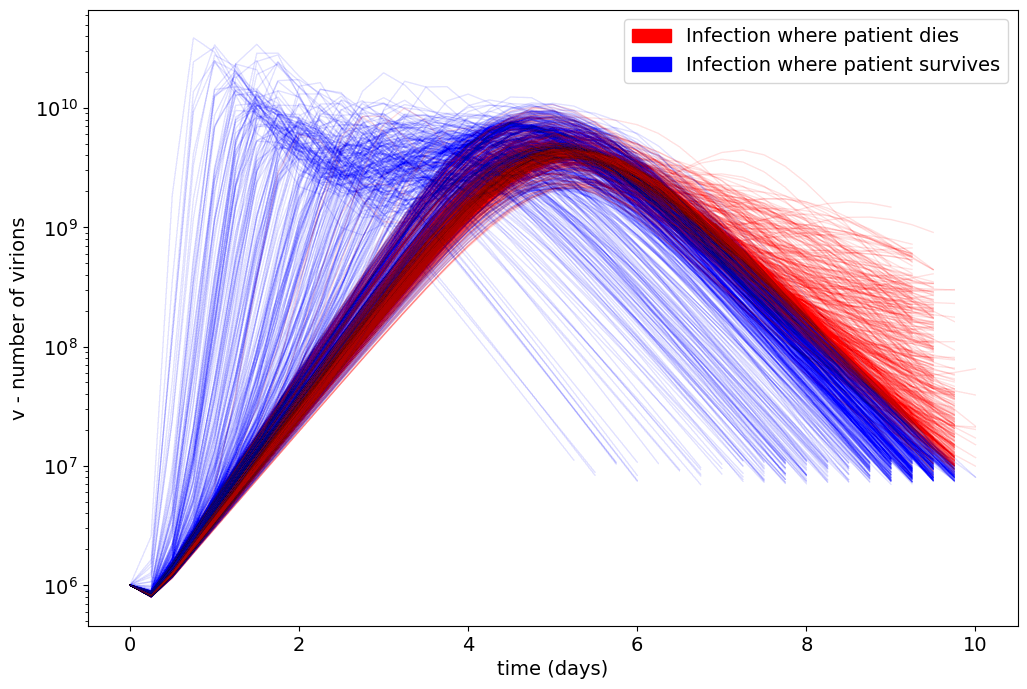

In [29]:
import matplotlib.patches as mpatches

for j in range(1000):
    for k in range(0,10):
        Vcurve = n_i_lists[k + numberpeople1000s * j][0]
        if Deaths[j]:
            plt.semilogy(x[0:len(Vcurve)], Vcurve, 'r', linewidth=1, alpha = 0.01)
        else:
            plt.semilogy(x[0:len(Vcurve)], Vcurve, 'b', linewidth=1, alpha = 0.01)


red_patch = mpatches.Patch(color='red', label='Infection where patient dies')
blue_patch = mpatches.Patch(color='blue', label='Infection where patient survives')

plt.legend(handles=[red_patch, blue_patch])
plt.ylabel('v - number of virions')
plt.xlabel('time (days)')
plt.savefig('Plots/v_bpm_surv_dead.pdf', dpi=1200,bbox_inches='tight')
plt.show()

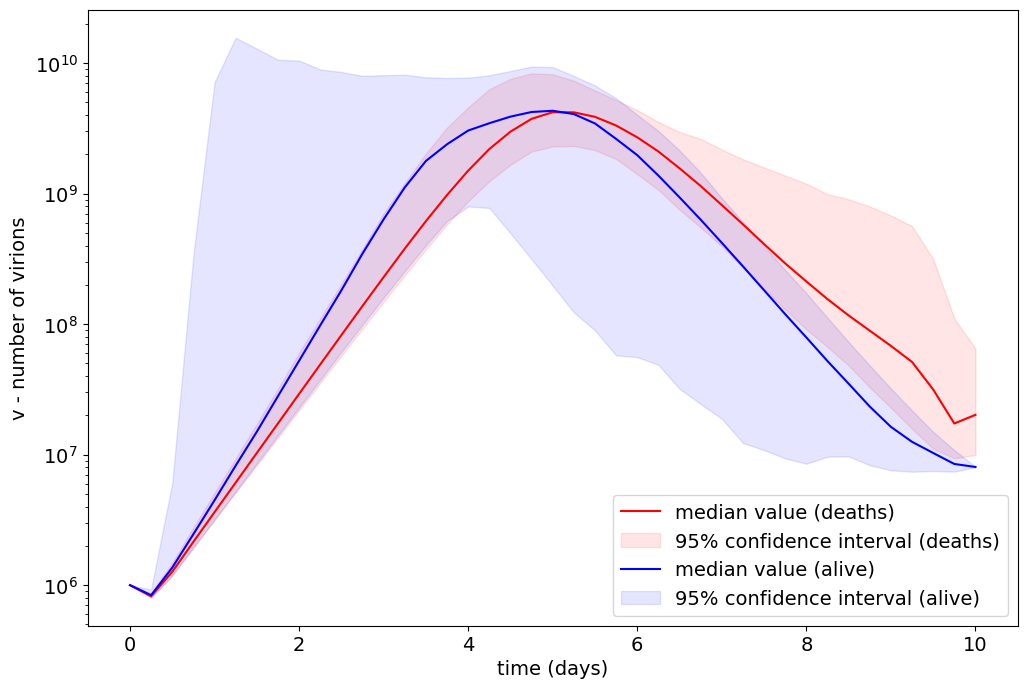

In [30]:
#plot median virion count over time, with 95% confidence interval
#we do this for dead and alive seperately
#initialise arrays
x = np.linspace(0, 10, 41)
y_d = np.zeros(41)
y_a = np.zeros(41)
meanV_d = np.zeros(41)
meanV_a = np.zeros(41)
ci_u_d= np.zeros(41)
ci_l_d = np.zeros(41)
ci_u_a= np.zeros(41)
ci_l_a = np.zeros(41)
for i in range(0, 41):
    v_i_d = []
    v_i_a = []
    for j in range(1000):
        for k in range(0,int(numberpeople1000s)):
            L = Lifespans[j]
            gens = int(L / g)
            if i <= gens:
                if Deaths[j]:
                    v_i_d.append(n_i_lists[k + int(numberpeople1000s) * j][0][i])
                else:
                    v_i_a.append(n_i_lists[k + int(numberpeople1000s) * j][0][i])

    #calculate median, mean and confidence interval
    y_d[i] = np.median(np.array(v_i_d))
    ci_u_d[i] = np.percentile(np.array(v_i_d), 97.5)
    ci_l_d[i] = np.percentile(np.array(v_i_d), 2.5)
    meanV_d[i] = np.mean(np.array(v_i_d))

    y_a[i] = np.median(np.array(v_i_a))
    ci_u_a[i] = np.percentile(np.array(v_i_a), 97.5)
    ci_l_a[i] = np.percentile(np.array(v_i_a), 2.5)
    meanV_a[i] = np.mean(np.array(v_i_a))

#plot
fig, ax = plt.subplots()
ax.semilogy(x,y_d, label = 'median value (deaths)', color='r')
ax.fill_between(x, (ci_l_d), (ci_u_d), color='r', alpha=.1, label="95% confidence interval (deaths)")
ax.semilogy(x,y_a, label = 'median value (alive)', color='b')
ax.fill_between(x, (ci_l_a), (ci_u_a), color='b', alpha=.1, label="95% confidence interval (alive)")
ax.legend()
plt.ylabel('v - number of virions')
plt.xlabel('time (days)')
plt.savefig('Plots/v_bpm_surv_dead_CI.pdf', dpi=1200,bbox_inches='tight')
plt.show()


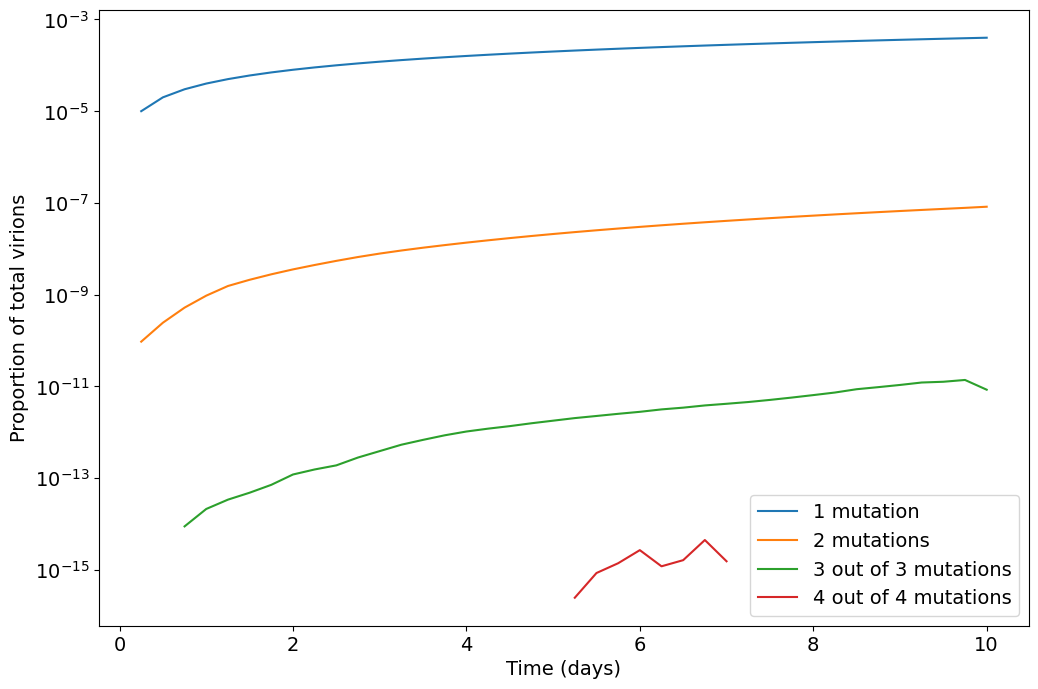

In [16]:
#We calculate the totals of each type of virion
n_totals = np.zeros((6,41))
for i in range(0,1000 * numberpeople1000s):
    for j in range(0,6):
        n_totals[j,0:len(n_i_lists[i][j])] += n_i_lists[i][j]
N_TOTAL = np.sum(n_totals, axis = 0)

#set up time values
timevals = np.linspace(0,10,41)

#Set up plot
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 14
fig = plt.figure()

#We plot the proportions of each virion type over time
for i in range(1,6):
    prop = n_totals[i,:] / N_TOTAL
    myrange = np.where(prop>0)
    #create a label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"
    if len(myrange[0]) > 0:
        plt.semilogy(timevals[myrange], prop[myrange], label = mylabel)
plt.legend(loc='best')
plt.ylabel('Proportion of total virions')
plt.xlabel('Time (days)')
plt.savefig('Plots/prop_standard.pdf', dpi=1200,bbox_inches='tight')
plt.show()

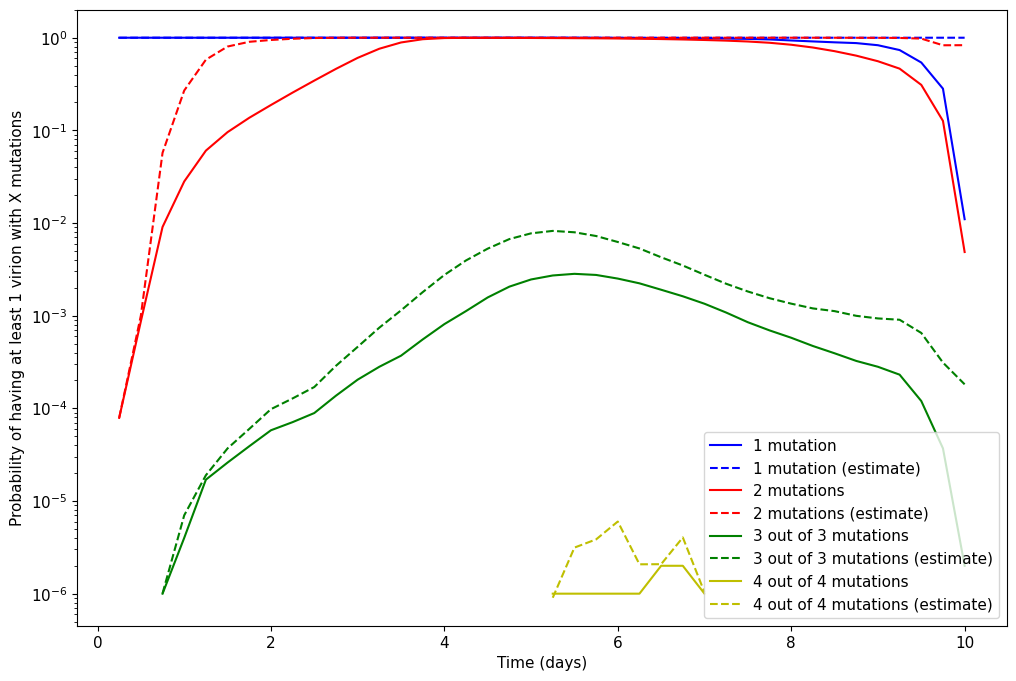

In [17]:
#We calculate the proportion / probability of an individual having at least one of a virion type
n_totals_prob = np.zeros((5,41))
for i in range(0,1000 * numberpeople1000s):
    for j in range(1,6):
        myN = n_i_lists[i][j]
        if np.max(myN) > 0.5:
            myrange = np.where(myN>0)
            n_totals_prob[j-1,myrange] += 1
n_totals_prob = n_totals_prob / (1000 * numberpeople1000s)

#set up colors for the plot
plotcolors = ['b', 'r', 'g', 'y', 'k']

#Set up plot
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 11
fig = plt.figure()

for i in range(1,6):
    probs = n_totals_prob[i-1,:]
    myrange = np.where(probs>0)


    #make an estimate for the probability
    prop = n_totals[i,:] / N_TOTAL
    myrange = np.where(prop>0)
    probest = 1 - np.power((1 - prop[myrange]),meanV[myrange])

    #create our label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"
    if len(myrange[0]) > 0:
        plt.semilogy(timevals[myrange], probs[myrange], plotcolors[i-1],label = mylabel)
        plt.semilogy(timevals[myrange], probest, (plotcolors[i-1] + '--'), label = (mylabel + " (estimate)"))


plt.legend(loc='best')
plt.ylabel('Probability of having at least 1 virion with X mutations')
plt.xlabel('Time (days)')
plt.savefig('Plots/prob_standard_1.pdf', dpi=1200,bbox_inches='tight')
plt.show()

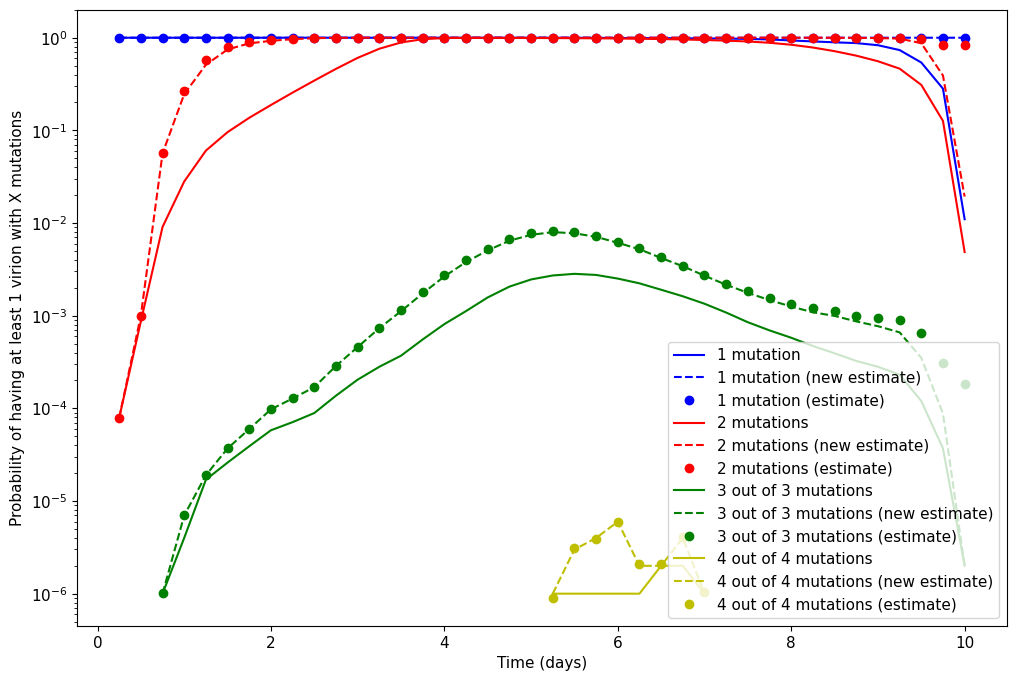

In [18]:
summation_term = np.zeros((5,41))
#We define a stronger estimate for the probability
#This uses the formula 1 - 1/1000 sum((1 - pk)^Vk)
for i in range(0,1000):
    #calculate Tk
    TK = np.zeros(41)
    for j in range(0, numberpeople1000s):
        for k in range(0,6):
            TK[0:len(n_i_lists[i + j*1000][k])] += n_i_lists[i + j*1000][k]
    #calculate Vk
    Vk = TK / numberpeople1000s
    #Calculate Tkm and pk
    for j in range(1,6):
        TKM = np.zeros(41)
        for k in range(0, numberpeople1000s):
            TKM[0:len(n_i_lists[i + k*1000][j])] += n_i_lists[i + k*1000][j]
        pk = TKM / TK
        summation_term[j-1,:] += np.power(1 - pk, Vk)
Proportion_Estimate = 1 - summation_term / 1000
        


#We calculate the proportion / probability of an individual having at least one of a virion type
n_totals_prob = np.zeros((5,41))
for i in range(0,1000 * numberpeople1000s):
    for j in range(1,6):
        myN = n_i_lists[i][j]
        if np.max(myN) > 0.5:
            myrange = np.where(myN>0)
            n_totals_prob[j-1,myrange] += 1
n_totals_prob = n_totals_prob / (1000 * numberpeople1000s)

#set up the colors for the plot
plotcolors = ['b', 'r', 'g', 'y', 'k']

for i in range(1,6):
    probs = n_totals_prob[i-1,:]
    myrange = np.where(probs>0)#

    #make an estimate for the probability
    prop = n_totals[i,:] / N_TOTAL
    probest = 1 - np.power((1 - prop[myrange]),meanV[myrange])

    myEST_i = Proportion_Estimate[i-1,:]
    myestrange = np.where(myEST_i>0)

    #create our label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"

    if len(myrange[0]) > 0:
        plt.semilogy(timevals[myrange], probs[myrange], plotcolors[i-1],label = mylabel)
        plt.semilogy(timevals[myestrange], myEST_i[myestrange], (plotcolors[i-1] + '--'), label = (mylabel + " (new estimate)"))
        plt.semilogy(timevals[myrange], probest, (plotcolors[i-1] + 'o'), label = (mylabel + " (estimate)"))



plt.legend(loc='best')
plt.ylabel('Probability of having at least 1 virion with X mutations')
plt.xlabel('Time (days)')
plt.savefig('Plots/prob_standard_2.pdf', dpi=1200,bbox_inches='tight')
plt.show()
    
    
        

In [19]:
#Set parameters
p = 10**-5
mu = [1, p, p**2, p**3, p**4, p**5]
mu[0] -= np.sum(mu[1:])
initial_viral_load = 1e6

#Number of people (in 1000s)
numberpeople1000s = 1e7

#Initialise lists
ns = []
n_i_lists = []

#Loop through and do a BPM for each person
for i in range(0,len(Lifespans)):
    print(str((i + 1) / len(Lifespans) * 100 ) + "%")
    t = Lifespans[i]
    #t = 7
    r = r_vals[i]
    #r = np.ones(120) * 2

    out = np.array(BPM_st_vectorised(t,g,r,mu,initial_viral_load * numberpeople1000s))
    ns.append(np.sum(out))
    ni_list = []
    for k in range(0, 6):
        ni_list.append(out[:,k])
    n_i_lists.append(ni_list)



0.1%
0.2%
0.3%
0.4%
0.5%
0.6%
0.7000000000000001%
0.8%
0.8999999999999999%
1.0%
1.0999999999999999%
1.2%
1.3%
1.4000000000000001%
1.5%
1.6%
1.7000000000000002%
1.7999999999999998%
1.9%
2.0%
2.1%
2.1999999999999997%
2.3%
2.4%
2.5%
2.6%
2.7%
2.8000000000000003%
2.9000000000000004%
3.0%
3.1%
3.2%
3.3000000000000003%
3.4000000000000004%
3.5000000000000004%
3.5999999999999996%
3.6999999999999997%
3.8%
3.9%
4.0%
4.1000000000000005%
4.2%
4.3%
4.3999999999999995%
4.5%
4.6%
4.7%
4.8%
4.9%
5.0%
5.1%
5.2%
5.3%
5.4%
5.5%
5.6000000000000005%
5.7%
5.800000000000001%
5.8999999999999995%
6.0%
6.1%
6.2%
6.3%
6.4%
6.5%
6.6000000000000005%
6.7%
6.800000000000001%
6.9%
7.000000000000001%
7.1%
7.199999999999999%
7.3%
7.3999999999999995%
7.5%
7.6%
7.7%
7.8%
7.9%
8.0%
8.1%
8.200000000000001%
8.3%
8.4%
8.5%
8.6%
8.7%
8.799999999999999%
8.9%
9.0%
9.1%
9.2%
9.3%
9.4%
9.5%
9.6%
9.700000000000001%
9.8%
9.9%
10.0%
10.100000000000001%
10.2%
10.299999999999999%
10.4%
10.5%
10.6%
10.7%
10.8%
10.9%
11.0%
11.1%
11.2000

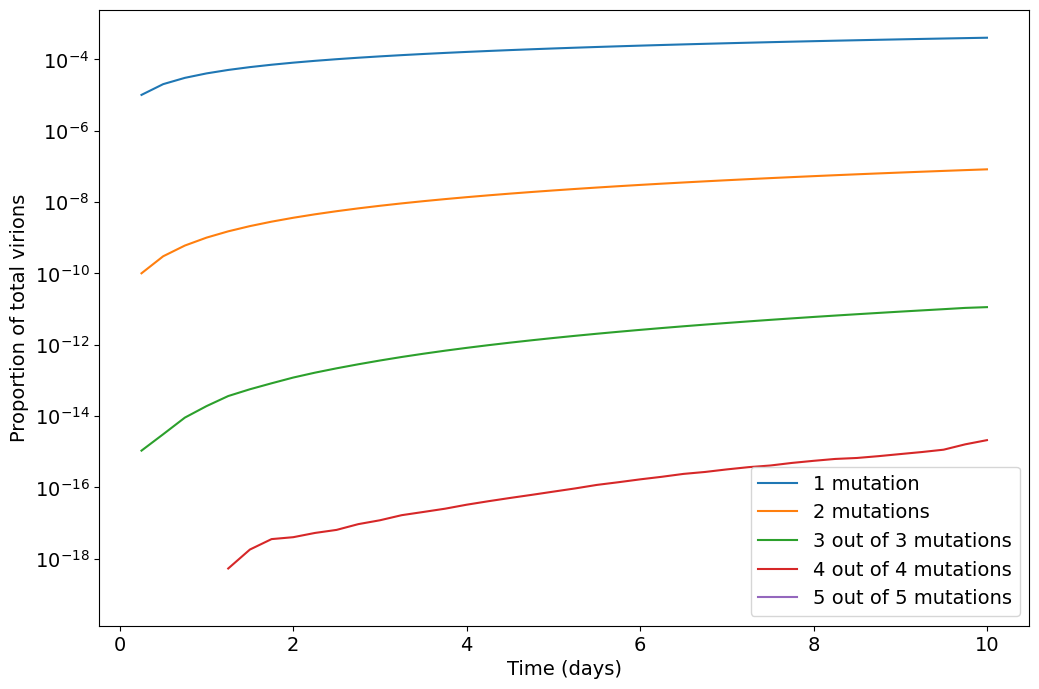

In [20]:
#We calculate the totals of each type of virion
n_totals = np.zeros((6,41))
for i in range(0,1000):
    for j in range(0,6):
        n_totals[j,0:len(n_i_lists[i][j])] += n_i_lists[i][j]
N_TOTAL = np.sum(n_totals, axis = 0)

#set up time values
timevals = np.linspace(0,10,41)

#Set up plot
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 14
fig = plt.figure()

#We plot the proportions of each virion type over time
for i in range(1,6):
    prop = n_totals[i,:] / N_TOTAL
    myrange = np.where(prop>0)
    #create a label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"
    if len(myrange[0]) > 0:
        plt.semilogy(timevals[myrange], prop[myrange], label = mylabel)
plt.legend(loc='best')
plt.ylabel('Proportion of total virions')
plt.xlabel('Time (days)')
plt.savefig('Plots/prop_quick.pdf', dpi=1200,bbox_inches='tight')
plt.show()

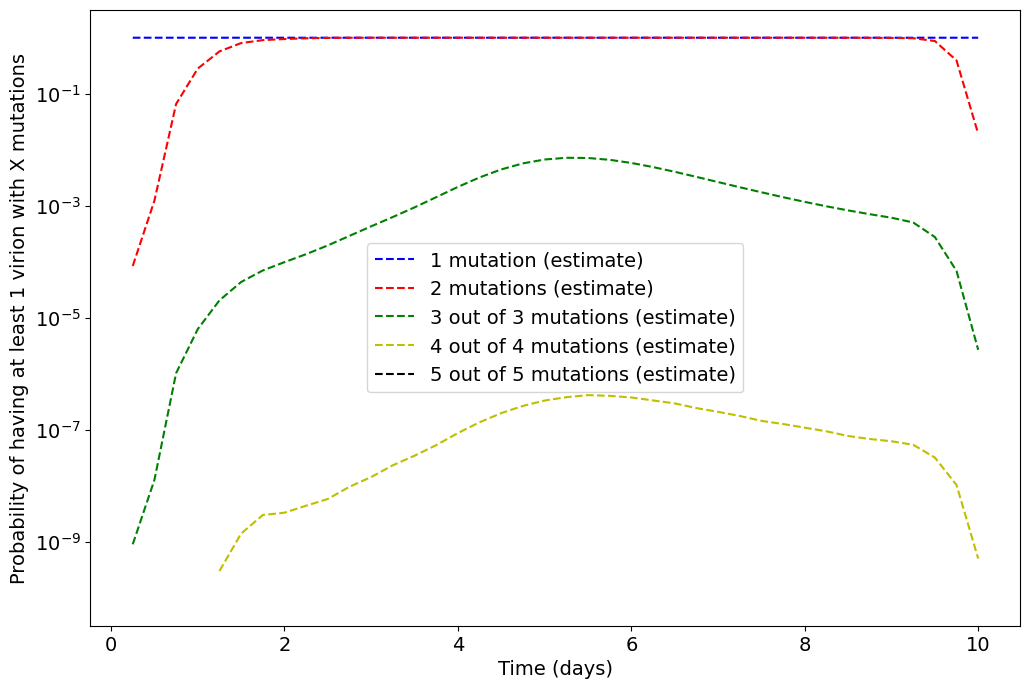

In [21]:
from decimal import *

#set up colors for the plot
plotcolors = ['b', 'r', 'g', 'y', 'k']

for i in range(1,6):
    #make an estimate for the probability
    
    prop = (n_totals[i,:] / N_TOTAL)
    myrange = np.where((prop)>0)

    mynewprop = []
    mynewNTOTAL = []
    result = []


    for k in range(len(myrange[0])):
        mynewprop.append(1 - Decimal(float(prop[myrange[0][k]])))
        mynewNTOTAL.append(Decimal(N_TOTAL[myrange[0][k]] / (1000 * numberpeople1000s)))
        result.append(1 - mynewprop[-1] ** mynewNTOTAL[-1])


    #create our label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"

    if len(myrange[0]) > 0:
        plt.semilogy(timevals[myrange], result, (plotcolors[i-1] + '--'), label = (mylabel + " (estimate)"))


plt.legend(loc='best')
plt.ylabel('Probability of having at least 1 virion with X mutations')
plt.xlabel('Time (days)')
plt.savefig('Plots/prob_quick_1.pdf', dpi=1200,bbox_inches='tight')
plt.show()

In [23]:
with open('n_list.pkl', 'rb') as f:

    loaded_n_list = pickle.load(f) # deserialize using load()
f.close()

n_i_lists = loaded_n_list